In [2]:
!pip install -q -U git+https://github.com/Farama-Foundation/MAgent2

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from magent2.environments import battle_v4
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import random
from collections import deque
from tqdm import tqdm

In [4]:
env = battle_v4.parallel_env(map_size=45,max_cycles=1000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
config = {
    "obs_shape": env.observation_space("red_0").shape,
    "action_dims": int(env.action_space("red_0").n),
    "buffer_alpha": 0.6,
    "beta": 0.4,
    "beta_increment": 1e-3,
    "learning_rate": 0.0005,
    "buffer_size": 10000,
    "epsilon": 1.0,
    "epsilon_decay": 0.998,
    "epsilon_min": 0.05,
    "gamma": 0.98, # discount
    "batch_size": 218,
    "tau": 0.005, # soft update,
    "red_update_interval": 2,
    "blue_update_interval": 2,
    "num_episode": 50,
    "num_step": 1000,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [6]:
class QNetwork(nn.Module):
  def __init__(self, obs_shape, actions_dim, kernel_size=3, stride=1, padding=1):
      super(QNetwork, self).__init__()

      self.conv1 = nn.Conv2d(
          obs_shape[-1],
          32,
          kernel_size=kernel_size,
          stride=stride,
          padding=padding
      ) # 5 channels -> 32 features map
      self.conv2 = nn.Conv2d(
          32,
          64,
          kernel_size=kernel_size,
          stride=stride,
          padding=padding
      ) # 32 channels -> 64 features map

      self.fc1 = nn.Linear(
          64 * obs_shape[0] * obs_shape[1],
          128
      ) # Flat 64 * 13 * 13 -> 128 neurons
      self.fc2 = nn.Linear(
          128,
          actions_dim
      ) # 128 neurons -> 1 action

  def forward(self, x):
      x = x.permute(0, 3, 1, 2) # (batch_size, width, height, channels) -> (batch_size, channels, width, height)

      # Convolution with ReLU activation
      x = torch.relu(self.conv1(x))
      x = torch.relu(self.conv2(x))

      x = x.reshape(x.size(0), -1) # (batch_size, flatten_size)

      # Fully connected layers
      x = torch.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [8]:
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity  # Number of leaf nodes (maximum buffer size)
        self.tree = np.zeros(2 * capacity - 1)  # Tree structure to store priorities
        self.data = np.zeros(capacity, dtype=object)  # Circular buffer for data
        self.write = 0  # Pointer to the next data entry

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):  # If we reach a leaf node
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1

        return idx, self.tree[idx], self.data[data_idx]

    def size(self):
        """Returns the current size of the buffer."""
        if self.write < self.capacity:
            return self.write  # If the buffer isn't full yet
        else:
            return self.capacity  # Buffer is full when write pointer has wrapped around

In [9]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha):
        self.tree = SumTree(capacity)
        self.alpha = alpha  # Controls how much prioritization is used (0 - no prioritization)
        self.capacity = capacity

    def add(self, state, action, reward, next_state, done, error):
        priority = (abs(error) + 1e-5) ** self.alpha
        self.tree.add(priority, (state, action, reward, next_state, done))

    def sample(self, batch_size, beta):
        batch = []
        idxs = []
        priorities = []
        segment = self.tree.total() / batch_size

        for i in range(batch_size):
            s = random.uniform(segment * i, segment * (i + 1))
            idx, priority, data = self.tree.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(priority)

        sampling_probs = priorities / self.tree.total()
        weights = (len(self) * sampling_probs) ** -beta
        weights /= weights.max()

        states, actions, rewards, next_states, dones = zip(*batch)

        return (
            idxs,
            torch.cat(states).to('cuda'),
            torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(config["device"]),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(config["device"]),
            torch.cat(next_states).to(config["device"]),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(config["device"]),
            torch.tensor(weights, dtype=torch.float32).unsqueeze(1).to(config["device"])
        )

    def update(self, idxs, errors):
        for idx, error in zip(idxs, errors):
            priority = (abs(error) + 1e-5) ** self.alpha
            self.tree.update(idx, priority)

    def __len__(self):
        # Assuming the SumTree class has a `size` attribute or equivalent method
        return self.tree.size()

In [10]:
def update_network(network, target_network):
  target_network.load_state_dict(network.state_dict())

In [11]:
red_q_network = QNetwork(
    obs_shape=config["obs_shape"],
    actions_dim=config["action_dims"]
).to(config["device"])

red_target_q_network = QNetwork(
    obs_shape=config["obs_shape"],
    actions_dim=config["action_dims"]
).to(config["device"])

red_optimizer = optim.Adam(red_q_network.parameters(), lr=config["learning_rate"])
red_buffer = PrioritizedReplayBuffer(capacity=config["buffer_size"], alpha=config["buffer_alpha"])

update_network(red_q_network, red_target_q_network)
red_target_q_network.eval()

QNetwork(
  (conv1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=10816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=21, bias=True)
)

In [12]:
blue_q_network = QNetwork(
    obs_shape=config["obs_shape"],
    actions_dim=config["action_dims"]
).to(config["device"])

blue_target_q_network = QNetwork(
    obs_shape=config["obs_shape"],
    actions_dim=config["action_dims"]
).to(config["device"])

blue_optimizer = optim.Adam(blue_q_network.parameters(), lr=config["learning_rate"])
blue_buffer = PrioritizedReplayBuffer(capacity=config["buffer_size"], alpha=config["buffer_alpha"])

update_network(blue_q_network, blue_target_q_network)
blue_target_q_network.eval()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


QNetwork(
  (conv1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=10816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=21, bias=True)
)

In [13]:
pbar = tqdm(range(config["num_episode"]), desc="Training Double Q")
beta = config["beta"]

for episode in pbar:
    obs = env.reset()
    obs = obs[0] if isinstance(obs, tuple) else obs
    red_total_reward = 0
    blue_total_reward = 0
    blue_losses = []
    red_losses = []

    done_agents = set()
    beta = min(1.0, beta + config["beta_increment"])

    for step in range(config["num_step"]):
        actions = {}
        red_team = [agent for agent in env.agents if "red" in agent and agent not in done_agents]
        blue_team = [agent for agent in env.agents if "blue" in agent and agent not in done_agents]

        if len(red_team) > 0:
            red_team_state = torch.stack(
                [torch.tensor(obs[agent], dtype=torch.float32) for agent in red_team]
            ).to(config["device"])

            with torch.no_grad():
                red_q_values = red_q_network(red_team_state)
                network_actions = torch.argmax(red_q_values, dim=1)

            random_actions = torch.randint(0, config["action_dims"], (len(red_team),), device=config["device"])

            red_actions = torch.where(
                torch.rand(len(red_team), device=config["device"]) < config["epsilon"],
                random_actions,
                network_actions
            ).to(config["device"])

            actions.update({agent: action.item() for agent, action in zip(red_team, red_actions)})

        if len(blue_team) > 0:
            blue_team_state = torch.stack(
                [torch.tensor(obs[agent], dtype=torch.float32) for agent in blue_team]
            ).to(config["device"])

            with torch.no_grad():
                blue_q_values = blue_q_network(blue_team_state)
                network_actions = torch.argmax(blue_q_values, dim=1)

            random_actions = torch.randint(0, config["action_dims"], (len(blue_team),), device=config["device"])

            blue_actions = torch.where(
                torch.rand(len(blue_team), device=config["device"]) < config["epsilon"],
                random_actions,
                network_actions
            ).to(config["device"])

            actions.update({agent: action.item() for agent, action in zip(blue_team, blue_actions)})

        next_obs, rewards, terminations, truncations, infos = env.step(actions)
        dones = {agent: terminations.get(agent, False) or truncations.get(agent, False) for agent in env.agents}

        for agent in red_team:
            if agent in done_agents:
                continue
            state = torch.tensor(obs[agent], dtype=torch.float32).unsqueeze(0).to(config["device"])
            action = actions[agent]
            reward = rewards.get(agent, 0.0)
            next_state = torch.tensor(next_obs[agent], dtype=torch.float32).unsqueeze(0).to(config["device"])
            done = dones.get(agent, False)

            error = 1.0
            red_buffer.add(state, action, reward, next_state, done, error)
            red_total_reward += reward

            if done:
                done_agents.add(agent)

        for agent in blue_team:
            if agent in done_agents:
                continue
            state = torch.tensor(obs[agent], dtype=torch.float32).unsqueeze(0).to(config["device"])
            action = actions[agent]
            reward = rewards.get(agent, 0.0)
            next_state = torch.tensor(next_obs[agent], dtype=torch.float32).unsqueeze(0).to(config["device"])
            done = dones.get(agent, False)

            error = 1.0
            blue_buffer.add(state, action, reward, next_state, done, error)
            blue_total_reward += reward

            if done:
                done_agents.add(agent)

        obs = next_obs

        if len(red_buffer) >= config["batch_size"]:
            idxs, states, actions, rewards, next_states, dones, weights = red_buffer.sample(config["batch_size"], beta)

            q_values = red_q_network(states).gather(1, actions)
            with torch.no_grad():
                next_actions = red_q_network(next_states).argmax(1, keepdim=True)
                next_q_values = red_target_q_network(next_states).gather(1, next_actions)
                target_q_values = rewards + (1 - dones) * config["gamma"] * next_q_values

            td_errors = torch.abs(q_values - target_q_values).detach().cpu().numpy()
            red_buffer.update(idxs, td_errors)

            loss = (torch.tensor(weights, dtype=torch.float32, device=config["device"]).squeeze() * F.mse_loss(q_values, target_q_values, reduction="none").squeeze()).mean()
            red_losses.append(loss.item())
            red_optimizer.zero_grad()
            loss.backward()
            red_optimizer.step()

        if len(blue_buffer) >= config["batch_size"]:
            idxs, states, actions, rewards, next_states, dones, weights = blue_buffer.sample(config["batch_size"], beta)

            q_values = blue_q_network(states).gather(1, actions)
            with torch.no_grad():
                next_actions = blue_q_network(next_states).argmax(1, keepdim=True)
                next_q_values = blue_target_q_network(next_states).gather(1, next_actions)
                target_q_values = rewards + (1 - dones) * config["gamma"] * next_q_values

            td_errors = torch.abs(q_values - target_q_values).detach().cpu().numpy()
            blue_buffer.update(idxs, td_errors)

            loss = (torch.tensor(weights, dtype=torch.float32, device=config["device"]).squeeze() * F.mse_loss(q_values, target_q_values, reduction="none").squeeze()).mean()
            blue_losses.append(loss.item())
            blue_optimizer.zero_grad()
            loss.backward()
            blue_optimizer.step()

    pbar.set_postfix({
        'Red Reward': red_total_reward,
        'Red Loss': red_losses[-1] if red_losses else 0,
        'Blue Reward': blue_total_reward,
        'Blue Loss': blue_losses[-1] if blue_losses else 0,
        'Epsilon': config['epsilon']
    })

    if config["epsilon"] > config["epsilon_min"]:
        config["epsilon"] *= config["epsilon_decay"]

Training Double Q:   0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-8-1a701bb6b123>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.tree[idx] = priority
<ipython-input-13-5c07a2c8fb3f>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = (torch.tensor(weights, dtype=torch.float32, device=config["device"]).squeeze() * F.mse_loss(q_values, target_q_values, reduction="none").squeeze()).mean()
<ipython-input-13-5c07a2c8fb3f>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = (torch.tensor(weight

In [14]:
torch.save(blue_q_network.state_dict(), "blue_doubleQ_default.pth")

In [ ]:
import numpy as np

np.save("red_losses.npy", np.array(red_losses))
np.save("blue_losses.npy", np.array(blue_losses))

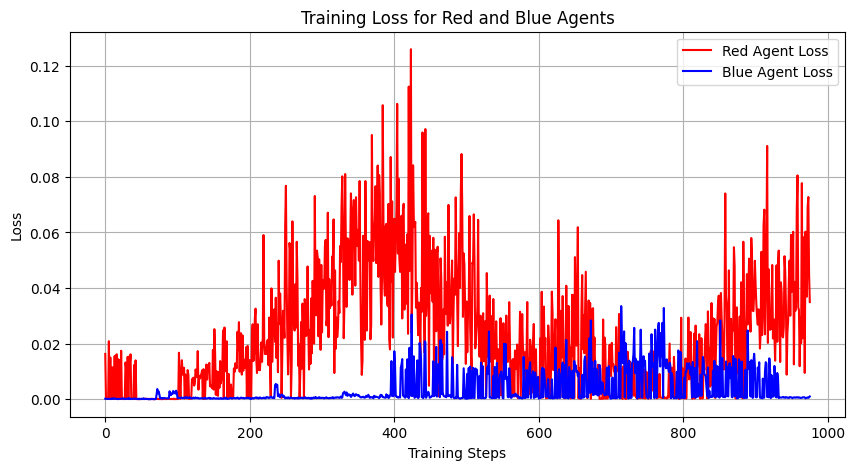

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
plt.plot(red_losses, label="Red Agent Loss", color="red")
plt.plot(blue_losses, label="Blue Agent Loss", color="blue")
plt.title("Training Loss for Red and Blue Agents")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)  # Add a grid for better visualization

# Display the plot
plt.show()